1. Clean the data and perform some EDA and visualization to get to know the data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

file_path = '/Users/bridgetholt/Desktop/Lab ML/airbnb_hw.csv'
data = pd.read_csv(file_path)

In [3]:
print(data.head(),'\n')
print(data.describe(),'\n')

    Host Id Host Since                                Name Neighbourhood   \
0   5162530        NaN     1 Bedroom in Prime Williamsburg       Brooklyn   
1  33134899        NaN     Sunny, Private room in Bushwick       Brooklyn   
2  39608626        NaN                Sunny Room in Harlem      Manhattan   
3       500  6/26/2008  Gorgeous 1 BR with Private Balcony      Manhattan   
4       500  6/26/2008            Trendy Times Square Loft      Manhattan   

  Property Type  Review Scores Rating (bin)        Room Type  Zipcode  Beds  \
0     Apartment                         NaN  Entire home/apt  11249.0   1.0   
1     Apartment                         NaN     Private room  11206.0   1.0   
2     Apartment                         NaN     Private room  10032.0   1.0   
3     Apartment                         NaN  Entire home/apt  10024.0   3.0   
4     Apartment                        95.0     Private room  10036.0   3.0   

   Number of Records  Number Of Reviews Price  Review Scores R

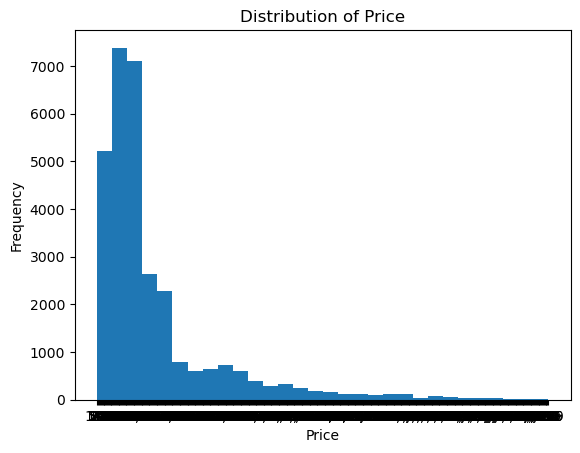

In [5]:
# Histogram for 'Price'
data['Price'].hist(bins=30, grid=False)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

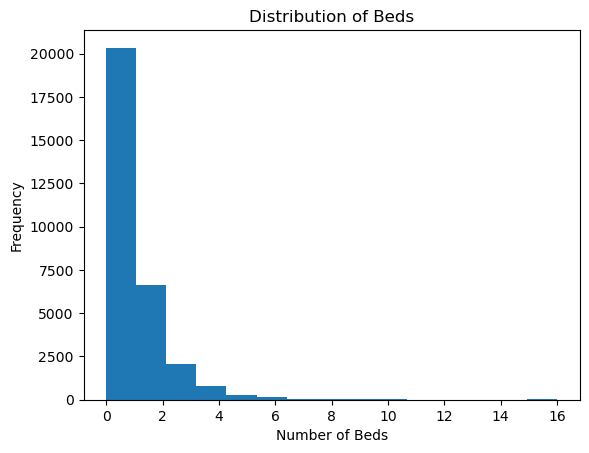

In [7]:
# Histogram for 'Beds'
data['Beds'].hist(bins=15, grid=False)
plt.title('Distribution of Beds')
plt.xlabel('Number of Beds')
plt.ylabel('Frequency')
plt.show()

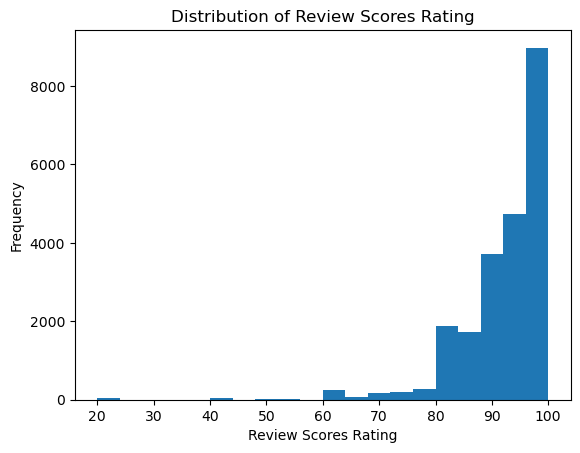

In [9]:
data['Review Scores Rating'].hist(bins=20, grid=False)
plt.title('Distribution of Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Frequency')
plt.show()

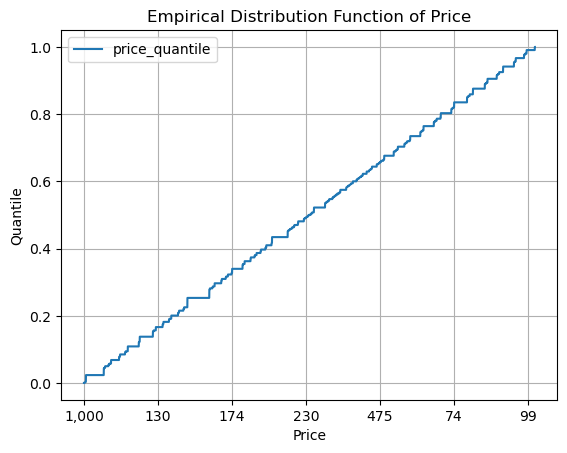

In [11]:
data['price_quantile'] = data['Price'].rank(method='average', pct=True)
data.sort_values('Price').plot(x='Price', y='price_quantile', grid=True)
plt.title('Empirical Distribution Function of Price')
plt.xlabel('Price')
plt.ylabel('Quantile')
plt.show()

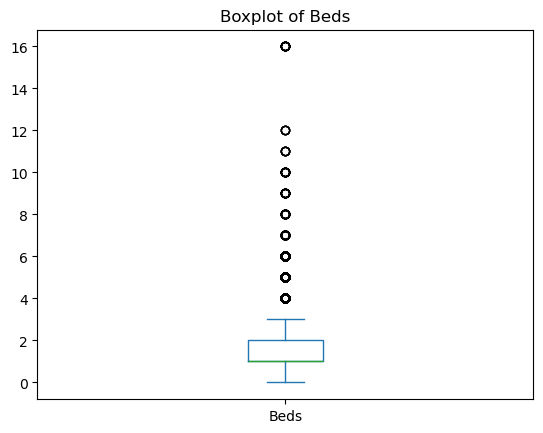

In [13]:
data['Beds'].plot.box()
plt.title('Boxplot of Beds')
plt.show()

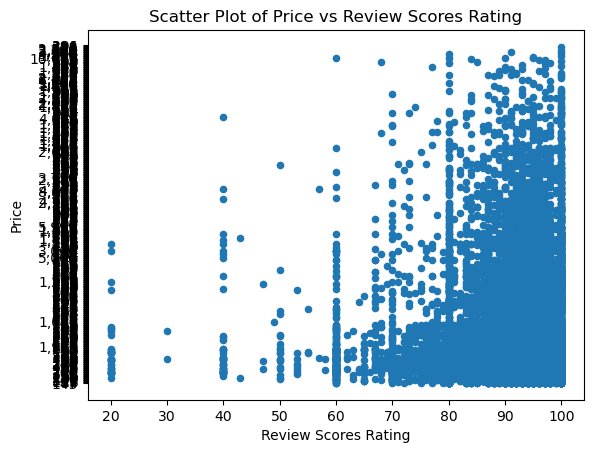

In [15]:
data.plot.scatter(y='Price', x='Review Scores Rating')
plt.title('Scatter Plot of Price vs Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price')
plt.show()

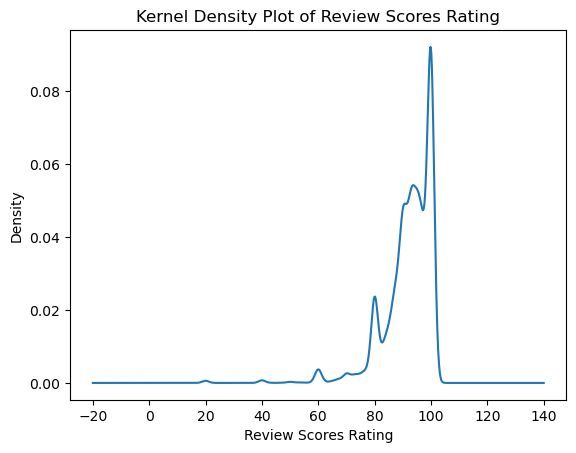

In [16]:
data['Review Scores Rating'].plot.density()
plt.title('Kernel Density Plot of Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Density')
plt.show()

2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.

In [20]:
data['Price'] = data['Price'].replace(r'[\$,]', '', regex=True).astype(float)
data['Beds'] = data['Beds'].fillna(data['Beds'].median())
data['Review Scores Rating'] = data['Review Scores Rating'].fillna(data['Review Scores Rating'].median())
data['Review Scores Rating (bin)'] = data['Review Scores Rating (bin)'].fillna(data['Review Scores Rating (bin)'].median())

In [22]:
y = data['Price']
X = data.drop(columns=['Price'])

X.columns = X.columns.str.strip()


In [24]:
categorical_features = ['Neighbourhood', 'Property Type', 'Room Type']
numeric_features = ['Beds', 'Number Of Reviews', 'Review Scores Rating']

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),  
            ('scaler', StandardScaler())  
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)  
    ])


In [28]:
X_transformed = preprocessor.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

print("Training data shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Test data shape (X_test, y_test):", X_test.shape, y_test.shape)

Training data shape (X_train, y_train): (24382, 34) (24382,)
Test data shape (X_test, y_test): (6096, 34) (6096,)


In [30]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [32]:
numeric_features = preprocessor.named_transformers_['num'].named_steps['poly'].get_feature_names_out(['Beds', 'Number Of Reviews', 'Review Scores Rating'])
X_train_n = pd.DataFrame(X_train[:, :len(numeric_features)], columns=numeric_features)
X_test_n = pd.DataFrame(X_test[:, :len(numeric_features)], columns=numeric_features)


In [34]:
reg_n = linear_model.LinearRegression().fit(X_train_n, y_train)
y_hat_n = reg_n.predict(X_test_n)
print('Numeric only R^2:', reg_n.score(X_test_n, y_test))
rmse_n = np.sqrt(mean_squared_error(y_test, y_hat_n))
print('Numeric only RMSE:', rmse_n)

Numeric only R^2: 0.1289857772188875
Numeric only RMSE: 190.84431908947408


In [36]:
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['Neighbourhood', 'Property Type', 'Room Type'])
X_train_c = pd.DataFrame(X_train[:, len(numeric_features):], columns=categorical_features)
X_test_c = pd.DataFrame(X_test[:, len(numeric_features):], columns=categorical_features)

In [38]:
reg_c = linear_model.LinearRegression().fit(X_train_c, y_train)
y_hat_c = reg_c.predict(X_test_c)
print('Categorical only R^2:', reg_c.score(X_test_c, y_test))
rmse_c = np.sqrt(mean_squared_error(y_test, y_hat_c))
print('Categorical only RMSE:', rmse_c)

Categorical only R^2: 0.13637846275180765
Categorical only RMSE: 190.03270292748172


In [40]:
X_train_all = pd.concat([X_train_n, X_train_c], axis=1)
X_test_all = pd.concat([X_test_n, X_test_c], axis=1)

In [42]:
reg_all = linear_model.LinearRegression().fit(X_train_all, y_train)
y_hat_all = reg_all.predict(X_test_all)
print('All variables R^2:', reg_all.score(X_test_all, y_test))
rmse_all = np.sqrt(mean_squared_error(y_test, y_hat_all))
print('All variables RMSE:', rmse_all)

All variables R^2: 0.20746646548009307
All variables RMSE: 182.0436091795326


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

complex_model = LinearRegression()
complex_model.fit(X_train_all, y_train)

y_train_pred_complex = complex_model.predict(X_train_all)
y_test_pred_complex = complex_model.predict(X_test_all)

rmse_train_complex = mean_squared_error(y_train, y_train_pred_complex, squared=False)
r2_train_complex = r2_score(y_train, y_train_pred_complex)

rmse_test_complex = mean_squared_error(y_test, y_test_pred_complex, squared=False)
r2_test_complex = r2_score(y_test, y_test_pred_complex)

print("Complex Model Results:")
print("Training RMSE:", rmse_train_complex)
print("Training R^2:", r2_train_complex)
print("Test RMSE:", rmse_test_complex)
print("Test R^2:", r2_test_complex)


Complex Model Results:
Training RMSE: 176.2362630078601
Training R^2: 0.1920385040060042
Test RMSE: 182.0436091795326
Test R^2: 0.20746646548009307


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The results highlight the models improvement as model complexity increases. The numeric-only model (RMSE: 190.84, R^2 0.13) and categorical-only model (RMSE: 190.03,R^2)show limited predictive power individually. When combining all variables, performance improves (RMSE: 182.04, R^2), suggesting value in leveraging both numeric and categorical data together.

The complex model, incorporating interactions and polynomial features, slightly enhances training performance (RMSE: 176.24,R^2) : 0.19) but achieves similar test results to the combined simple model. This indicates that while complexity adds depth, it does not drastically improve generalization.